In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv('learn.csv')
df.columns

Index([u'viewed', u'explored', u'certified', u'final_cc_cname_DI', u'LoE_DI',
       u'YoB', u'gender', u'grade', u'nevents', u'ndays_act', u'nplay_video',
       u'nchapters', u'nforum_posts', u'subject', u'instructor', u'no_courses',
       u'regis_to_start', u'course_duration', u'last_event_to_launch',
       u'presence/duration'],
      dtype='object')

## Load the data, remove records of inactive students and impute missing values. 

Churn = 1 for those who didn't complete rhe course

In [6]:
df = pd.read_csv('learn.csv')

# remove inactive students: those with 'nevents' being 'NaN'.
df = df[pd.notnull(df.nevents)]

del df['final_cc_cname_DI'] # will use it later
df.index = range(df.shape[0])

temp = []
# Convert cathegoricals and impute missing values: 
for i in xrange(df.shape[0]): # df.shape[0]
    if df['LoE_DI'][i] == 'Less than Secondary':
        temp.append(1)
    elif df['LoE_DI'][i] == 'Secondary':
        temp.append(2)
    elif df['LoE_DI'][i] == 'Bachelor\'s':
        temp.append(3)
    elif df['LoE_DI'][i] == 'Master\'s':
        temp.append(4)
    elif df['LoE_DI'][i] == 'Doctorate':
        temp.append(5)
    else:
        temp.append(0)
        
df['LoE_DI'] = temp
temp = []
        
for i in xrange(df.shape[0]):
    if df['gender'][i] == 'm': #male
        temp.append(1)
    elif df['gender'][i] == 'f':
        temp.append(2)
    else:
        temp.append(0)
        
df['gender'] = temp
del temp

imp1=Imputer(missing_values='NaN',strategy='mean',axis=1)
df['nchapters']=imp1.fit_transform(df['nchapters']).transpose()

#imp2=Imputer(missing_values='NaN',strategy='median',axis=1) #didn't work-get back to this later
df['nplay_video']=imp1.fit_transform(df['nplay_video']).transpose()
df['YoB']=imp1.fit_transform(df['YoB']).transpose()

#convert YoB to age:
course_yr = 2012.5
df['Age'] = df['YoB'].map(lambda x: course_yr - x)

#Convert 'certified' to 'Churn'
Churn = df['certified'].map(lambda x: 1-x)
    
del df['YoB'], df['certified'], df['grade']

In [7]:
df.head()

,viewed,explored,LoE_DI,gender,nevents,ndays_act,nplay_video,nchapters,nforum_posts,subject,instructor,no_courses,regis_to_start,course_duration,last_event_to_launch,presence/duration,Age
0,1,1,0,0,502,16,50.000000,12,0,10000000,366000,15,-4.000000,15.714286,31.857143,2.027273,27.011261
1,1,0,0,0,42,6,115.972094,3,0,1900000,600000,4,-10.285714,23.285714,8.714286,0.374233,27.011261
2,1,0,0,0,70,3,115.972094,3,0,1900000,600000,7,-3.571429,23.285714,0.571429,0.024540,27.011261
3,1,0,0,0,17,2,115.972094,2,0,500000000,500000,7,-1.285714,20.571429,14.571429,0.708333,27.011261
4,1,0,0,0,32,1,115.972094,3,0,500000000,500000,2,15.000000,20.571429,15.000000,0.729167,27.011261


In [4]:
z = [df['ndays_act'][i] for i in xrange(df.shape[0]) if not pd.isnull(df['ndays_act'][i])]
len(z)/float(df.shape[0])

1.0

## The churn rate is high.

In [12]:
z = [Churn[i] for i in xrange(df.shape[0]) if Churn[i] == 1]
print "Churn rate is %d%%." % (100*len(z)/df.shape[0])

Churn rate is 96%.


## Setting necessary learning, validation and plotting functions

In [13]:
def normalize(dat_frm): # normalize the features
    from sklearn import preprocessing
    X = dat_frm.as_matrix().astype(np.float)
    #return scaler.fit_transform(X)
    return preprocessing.scale(X)

def accuracy(y_true,y_pred): 
    return np.mean(y_true == y_pred)

In [14]:
def run_cv(X,features,y,clf_class,**kwargs): # makes cross-validated learning and predictions
    
    from sklearn.cross_validation import KFold
    no_features = X.shape[1]
    n_folds = 3
    
    kf = KFold(len(y),n_folds=n_folds,shuffle=True)
    y_pred = y.copy()
    ftr_impr = [0 for i in xrange(no_features)]
    
    #Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier 
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        
        if clf_class == RF:
            for i in xrange(no_features):
                ftr_impr[i] += clf.feature_importances_[i]/n_folds
            
        #print type(clf.feature_importances_)
    
    #print clf.get_params() 
    #for i in xrange(len(features)):
     #   print "%s: %.4f" % (features[i], ftr_impr[i]/n_folds) 
    
    imprt = {} # feature importances for random in case of forrest classifier
    if clf_class == RF:
        for i in xrange(no_features):
            imprt[features[i]] = ftr_impr[i]
            #print "%s: %.3f" % (features[i], ftr_impr[i])        
    return y_pred, imprt    


##Churn prediction using random forrest classifier

Random forest accuracy: 0.987 .


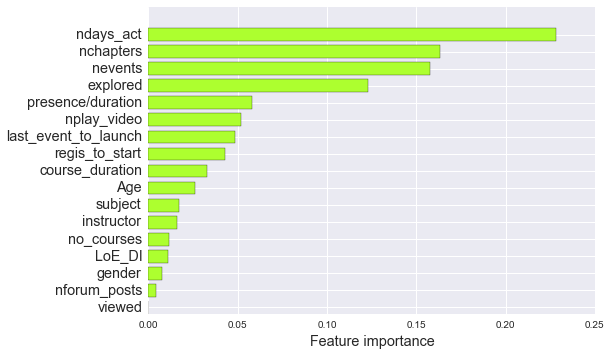

In [15]:
from sklearn.ensemble import RandomForestClassifier as RF
#from sklearn.neighbors import KNeighborsClassifier as KNN

X = normalize(df)
res = run_cv(X,df.columns, Churn,RF)
churn_pred = res[0]
feat_impr = res[1]
print "Random forest accuracy: %.3f" % accuracy(Churn, churn_pred)

import operator
feat = []
impr = []
fi = sorted(feat_impr.items(), key=operator.itemgetter(1))
for i in xrange(len(feat_impr)):
    feat.append(fi[i][0])
    impr.append(fi[i][1])

N = X.shape[1]
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

import seaborn as sns
sns.set_style('darkgrid')

p1 = plt.barh(ind, impr, width, color='greenyellow')

plt.xlabel('Feature importance', fontsize = 'x-large')
plt.yticks(ind+width/2., feat,rotation=0, fontsize = 'x-large')
plt.savefig('feat_impr_certify.eps', format='eps')

plt.show()


## How good is the classifier?

## Confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrices = [
    ( "Random Forest", confusion_matrix(Churn,run_cv(X,df.columns, Churn,RF)[0])),
    ]

In [35]:
def plot_confusion_matrix(confusion_matrices):

	import matplotlib.pyplot as plt
	import numpy as np

	conf_arr = confusion_matrices
	
	norm_conf = []
	for i in conf_arr: 
	    a = 0
	    tmp_arr = []
	    a = sum(i, 0)
	    for j in i:
		tmp_arr.append(float(j)/float(a))
	    norm_conf.append(tmp_arr)
	
	fig = plt.figure()
	plt.clf()
	ax = fig.add_subplot(111)
	ax.set_aspect(1)
	res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
			interpolation='nearest') 
	
	width = len(conf_arr)
	height = len(conf_arr[0])
	
	for x in xrange(width):
	    for y in xrange(height):
		ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
			    horizontalalignment='center',
			    verticalalignment='center', fontsize = 'xx-large')
		       
	alphabet = ['retention','churn']
	plt.ylabel('True class', fontsize = 'xx-large')
	plt.xlabel('Pred. class', fontsize = 'xx-large')
	plt.xticks(range(width), alphabet[:width], fontsize = 'xx-large')
	plt.yticks(range(height), alphabet[:height], fontsize = 'xx-large')
	plt.savefig('confusion_matrix.png', format='png')

## Recall and precision



Recall and precesion of random forrest classifier:  "recall=0.992, precision=0.994"



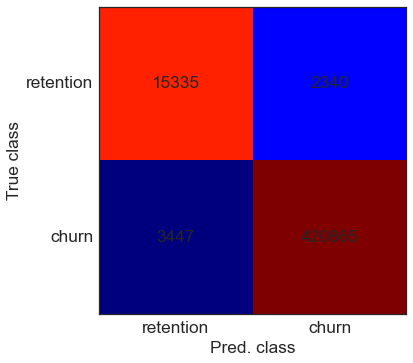

In [39]:
sns.set_style('white')
plot_confusion_matrix(rf_conf)
print "\n"

rf_conf = confusion_matrices[0][1]
print "Recall and precesion of random forrest classifier:  \"recall=%.3f, precision=%.3f\"\n" % (float(rf_conf[1][1])/
                                                  (rf_conf[1][1]+rf_conf[1][0]), 
                                                  float(rf_conf[1][1])/(rf_conf[1][1]+rf_conf[0][1]))
#print "SVC: \"recall=%.5f, precision=%.5f\"\n" % (float(svc_conf[1][1])/(svc_conf[1][1]+svc_conf[1][0]), float(svc_conf[1][1])/(svc_conf[1][1]+svc_conf[0][1]))

## The certification rate is quite low, whereas view rate is quite high (~70%). Viewing the course content is also the only oppurtunity to learn anything from the coruse. So, I make a churn predictor for 'course view' instead. 

In [42]:
df_view = df.copy()
is_view = df['viewed']
del df_view['viewed'], df_view['explored'], df_view['nevents'], df_view['ndays_act'], df_view['nplay_video'] 
del df_view['nchapters'], df_view['nforum_posts']

In [41]:
df_view.head()

,LoE_DI,gender,subject,instructor,no_courses,regis_to_start,course_duration,last_event_to_launch,presence/duration,Age
0,0,0,10000000,366000,15,-4.000000,15.714286,31.857143,2.027273,27.011261
1,0,0,1900000,600000,4,-10.285714,23.285714,8.714286,0.374233,27.011261
2,0,0,1900000,600000,7,-3.571429,23.285714,0.571429,0.024540,27.011261
3,0,0,500000000,500000,7,-1.285714,20.571429,14.571429,0.708333,27.011261
4,0,0,500000000,500000,2,15.000000,20.571429,15.000000,0.729167,27.011261


## Start with Random Forrest to get a sense of what features are important.

Random forest accuracy: 0.839


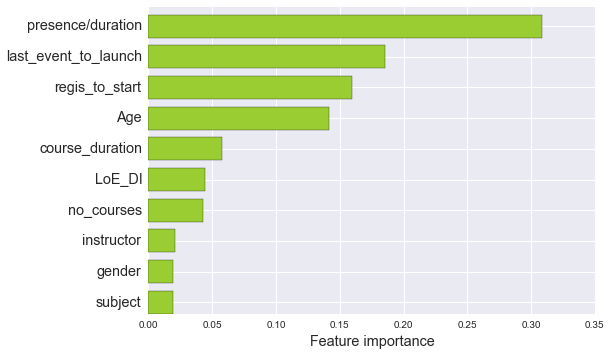

In [43]:
from sklearn.ensemble import RandomForestClassifier as RF
#from sklearn.svm import SVC

X = normalize(df_view)
res = run_cv(X, df_view.columns, is_view,RF)
is_view_pred = res[0]
feat_impr = res[1]
print "Random forest accuracy: %.3f" % accuracy(is_view, is_view_pred)

import operator
feat = []
impr = []
fi = sorted(feat_impr.items(), key=operator.itemgetter(1))
for i in xrange(len(feat_impr)):
    feat.append(fi[i][0])
    impr.append(fi[i][1])

N = len(feat)
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence
import seaborn as sns
sns.set_style('darkgrid')

p1 = plt.barh(ind, impr, width, color='yellowgreen')

plt.xlabel('Feature importance', fontsize = 'x-large')
plt.yticks(ind+width/2., feat,rotation=0, fontsize = 'x-large')
plt.savefig('feat_impr_view.eps', format='eps')

plt.show()

In [44]:
feat_impr

{'Age': 0.14193701143099716,
 'LoE_DI': 0.044386126470838075,
 'course_duration': 0.057887102146292141,
 'gender': 0.019491903765100467,
 'instructor': 0.020492367486380725,
 'last_event_to_launch': 0.18537645847486489,
 'no_courses': 0.043144624915417804,
 'presence/duration': 0.30820162185566768,
 'regis_to_start': 0.15977303753678793,
 'subject': 0.019309745917653186}

## Precision and recall

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrices = [
        ( "Random Forest", confusion_matrix(is_view, is_view_pred)),
    ]

rf_conf = confusion_matrices[0][1]
print "Accuracy, recal and precision of RF in predicting 'course view':\n\n  \"accuracy=%.3f, recall=%.3f, precision=%.3f\"\n" % (float(rf_conf[0][0]+rf_conf[1][1])/sum(rf_conf), float(rf_conf[1][1])/
                                                  (rf_conf[1][1]+rf_conf[1][0]), 
                                                  float(rf_conf[1][1])/(rf_conf[1][1]+rf_conf[0][1]))

Accuracy, recal and precision of RF in predicting 'course view':

  "accuracy=0.839, recall=0.909, precision=0.876"





Recall and precesion of random forrest classifier:  "recall=0.909, precision=0.876"



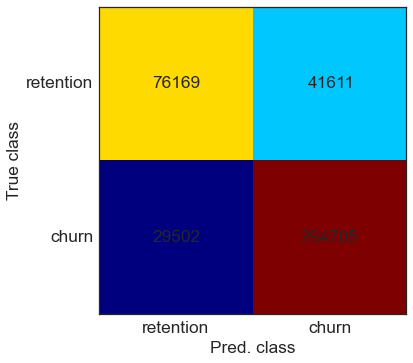

In [56]:
sns.set_style('white')
plot_confusion_matrix(rf_conf)
print "\n"

rf_conf = confusion_matrices[0][1]
print "Recall and precesion of random forrest classifier:  \"recall=%.3f, precision=%.3f\"\n" % (float(rf_conf[1][1])/
                                                  (rf_conf[1][1]+rf_conf[1][0]), 
                                                  float(rf_conf[1][1])/(rf_conf[1][1]+rf_conf[0][1]))
#print "SVC: \"recall=%.5f, precision=%.5f\"\n" % (float(svc_conf[1][1])/(svc_conf[1][1]+svc_conf[1][0]), float(svc_conf[1][1])/(svc_conf[1][1]+svc_conf[0][1]))

## Here, I compare RF with distance based algorithm kNN.

## ROC curves

In [57]:
def plot_roc(X, y):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('white')

    from sklearn.ensemble import RandomForestClassifier as RF
    from sklearn.neighbors import KNeighborsClassifier as KNN

    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import train_test_split
    
    n_classes = 2
    n_samples, n_features = X.shape
    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=0)

    # Learn to predict each class against the other
    classifier = RF(n_estimators=20)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])    
    roc_auc = auc(fpr, tpr)
    
    #KNN
    classifier = KNN(n_neighbors=20)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr2, tpr2, _ = roc_curve(y_test, y_score[:,1])    
    roc_auc2 = auc(fpr2, tpr2)


    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='RF (area = %0.4f)' % roc_auc)
    plt.plot(fpr2, tpr2, label='kNN (area = %0.4f)' % roc_auc2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 'x-large')
    plt.ylabel('True Positive Rate', fontsize = 'x-large')
    #plt.title('ROC curve')
    plt.legend(loc="lower right", fontsize = 'x-large')
    plt.savefig('roc_view.eps', format='eps')

    
    plt.show()


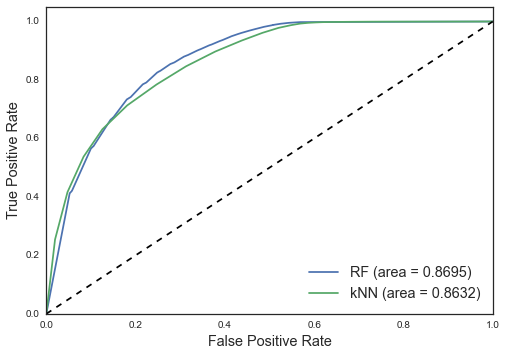

In [58]:
plot_roc(normalize(df_view), is_view)

## So, the model has a good accuracy in terms of predicting whether or not student view the course content at all. What about predicting probabilities of churn, which are more insightfull and actionable?

In [59]:
def run_prob_cv(X, y, clf_class, **kwargs):
    from sklearn.cross_validation import KFold

    kf = KFold(len(y), n_folds=2, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [60]:
from sklearn.neighbors import KNeighborsClassifier as KNN

#pred_prob = run_prob_cv(normalize(df_view), view, RF, n_estimators=10)
pred_prob = run_prob_cv(normalize(df_view), view, KNN, n_neighbors=100)

pred_churn = pred_prob[:,0]
is_churn = view == 0

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    if sum(pred_churn == prob) > 100: # keep large groups only to reduce sampling errors. 
        true_prob[prob] = np.mean(is_churn[pred_churn == prob])


Predicted probabilities are very close to actualy ones. 


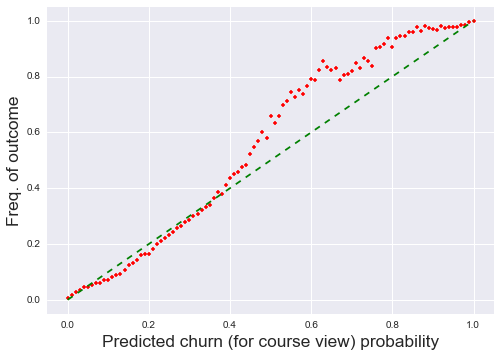

In [67]:
import collections
prob = collections.OrderedDict(sorted(true_prob.items()))

import seaborn as sns
sns.set_style('darkgrid')

#plt.plot(od.keys(), od.values(), color='b', markersize=12)
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.plot(prob.keys(), prob.values(), '.', c='r')
plt.plot([0, 1], [0, 1], 'k--', c='g');
plt.xlabel('Predicted churn (for course view) probability', fontsize = 'xx-large')
plt.ylabel('Freq. of outcome', fontsize = 'xx-large')
plt.savefig('prob.eps', format='eps')
print "\nPredicted probabilities are very close to actualy ones. "


## Repeat certification churn prediction this with part of the data with similar number of negative and and positive records. 

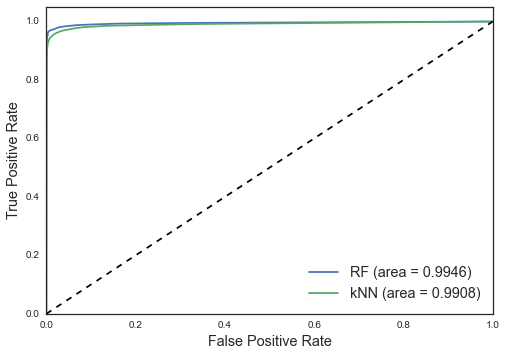

In [64]:
pos_to_neg = 1.5

df_pos = df[Churn == 1]
df_neg = df[Churn == 0]
df_pos.index = range(df_pos.shape[0])
# random sampling from df_pos
import random
rows = random.sample(df_pos.index, int(pos_to_neg*df_neg.shape[0]))
df_pos_samp = df_pos.ix[rows]
del df_pos

df_balanced = pd.concat([df_neg, df_pos_samp], ignore_index=True)

y = [0 for i in xrange(df_neg.shape[0])] + [1 for i in xrange(df_pos_samp.shape[0])]
y = np.array(y)


plot_roc(normalize(df_balanced), y)